Download TSLA data from [yahoo](https://finance.yahoo.com/quote/TSLA/history?period1=1546300800&period2=1657756800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asemenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
tesla_df = pd.read_csv('data/TSLA.csv')
tesla_df.Date = pd.to_datetime(tesla_df.Date)
tesla_df.set_index('Date', drop=True, inplace=True)
tesla_df['NextDayClose'] = tesla_df.Close.shift(-1)
tesla_df = tesla_df.reindex(
    pd.date_range(
        '2019-01-01', 
        tesla_df.index.max()
    ),
    method='backfill',
)
tesla_df.head()

,Open,High,Low,Close,Adj Close,Volume,NextDayClose
2019-01-01,61.220001,63.026001,59.759998,62.023998,62.023998,58293000,60.071999
2019-01-02,61.220001,63.026001,59.759998,62.023998,62.023998,58293000,60.071999
2019-01-03,61.400002,61.880001,59.476002,60.071999,60.071999,34826000,63.537998
2019-01-04,61.200001,63.599998,60.546001,63.537998,63.537998,36970500,66.991997
2019-01-05,64.344002,67.348000,63.549999,66.991997,66.991997,37756000,67.070000


In [4]:
tesla_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1290 entries, 2019-01-01 to 2022-07-13
Freq: D
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1290 non-null   float64
 1   High          1290 non-null   float64
 2   Low           1290 non-null   float64
 3   Close         1290 non-null   float64
 4   Adj Close     1290 non-null   float64
 5   Volume        1290 non-null   int64  
 6   NextDayClose  1289 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 80.6 KB


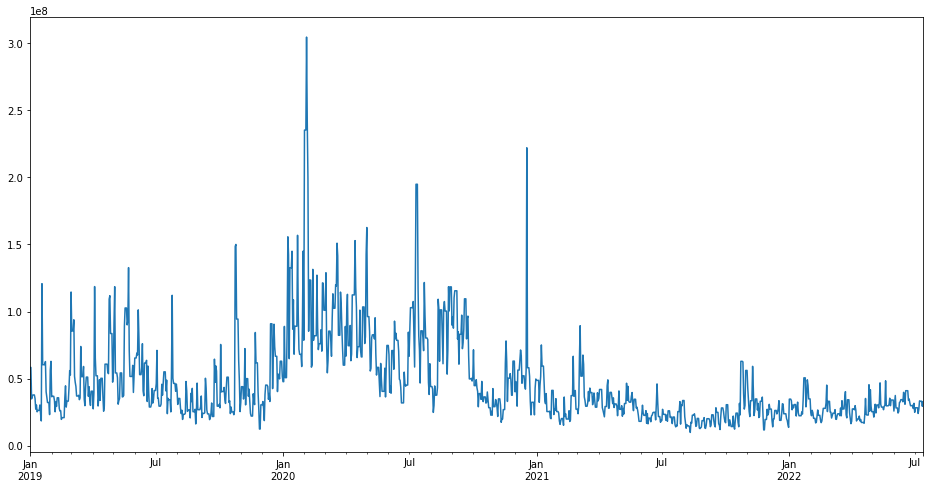

In [5]:
tesla_df.Volume.plot(figsize=(16, 8));

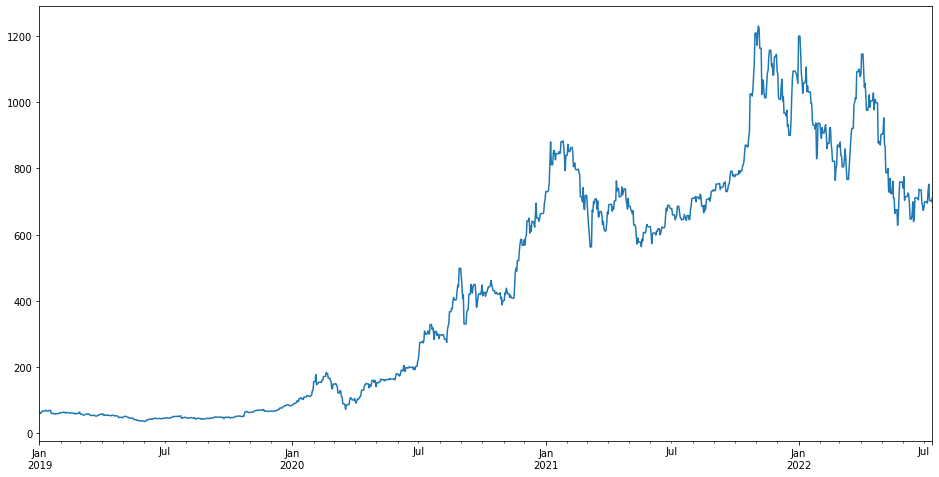

In [6]:
tesla_df.Close.plot(figsize=(16, 8));

In [7]:
elon_df = pd.concat([
    pd.read_csv('data/elon/2019.csv', index_col=0).set_index('id', drop=True),
    pd.read_csv('data/elon/2020.csv', index_col=0).set_index('id', drop=True),
    pd.read_csv('data/elon/2021.csv', index_col='id'),
])[['tweet', 'date']]
elon_df.rename(columns={'tweet': 'text'}, inplace=True)
elon_df['datetime'] = pd.to_datetime(elon_df['date'])
elon_df['date'] = pd.to_datetime(elon_df['datetime'].dt.date)
elon_df = elon_df.query("date >= '2019-01-01' and date < '2022-01-01'")
elon_df.drop_duplicates(inplace=True)
elon_df.head()

,text,date,datetime
id,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,2019-12-28 23:47:59
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,2019-12-28 23:38:57
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,2019-12-28 23:22:36
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,2019-12-28 22:42:53
1211051740562366464,@geofficient Pretty much,2019-12-28,2019-12-28 22:30:09


In [8]:
elon_df = elon_df[elon_df.text.str.lower().str.contains('tesla')]

In [9]:
def text_preprocessor(v: str) -> str:
    v = v.lower()
    v = re.sub(r'@[^\s]+', '', v)
    v = re.sub(r'https?://[^\s]+', '', v)
    v = re.sub(r'&\w+;', '', v)
    v = re.sub('\W+', ' ', v)
    v = v.strip()
    return v

In [10]:
empty_tweets = (
    elon_df.text
    .apply(text_preprocessor)
    .apply(lambda v: ' '.join(word for word in v.split() if word not in stop_words))
    .apply(lambda v: not not re.fullmatch('\W*', v))
)
print(elon_df[empty_tweets].shape)
elon_df[empty_tweets]

(77, 3)


,text,date,datetime
id,,,
1210263196457504768,@teslaownersSV @tesla_unplugged @TeslaOwnersof...,2019-12-26,2019-12-26 18:16:46
1205050955927932928,@SamTalksTesla https://t.co/z6zljrfUmb,2019-12-12,2019-12-12 09:05:11
1199718926218776576,@RenataKonkoly @Tesla @Teslarati @InsideEVs 🤣🤣,2019-11-27,2019-11-27 15:57:36
1189470830650019842,@TeslaStars @Tesla …,2019-10-30,2019-10-30 09:15:19
1187489371282276352,@MoWo91 @SpX_memes @SpaceX @Tesla @RenataKonko...,2019-10-24,2019-10-24 22:01:43
...,...,...,...
1382467430614667265,@AustinTeslaClub @TslaCC @teslaquadcities @tes...,2021-04-15,2021-04-15 00:00:00
1377901867313688578,@teslaownersSV @Tesla 🤣🤣,2021-04-02,2021-04-02 00:00:00
1373467434380783626,@TeslaPhx @CodingMark @EvaFoxU @jrosinski97 @d...,2021-03-21,2021-03-21 00:00:00


In [11]:
elon_df = elon_df[~empty_tweets]
elon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 1210777395738734593 to 1345208391958888448
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   text      1944 non-null   object        
 1   date      1944 non-null   datetime64[ns]
 2   datetime  1944 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 60.8+ KB


In [12]:
elon_df['tesla_grow_in_this_day'] = elon_df.apply(
    lambda r: tesla_df.loc[r['date']], 
    axis=1
).apply(
    lambda r: np.int32(r.NextDayClose > r.Open), 
    axis=1
)

In [13]:
elon_df['tesla_grow_in_this_day'].mean()

0.5961934156378601

In [14]:
elon_df.head()

,text,date,datetime,tesla_grow_in_this_day
id,,,,
1210777395738734593,@Erdayastronaut @teslaownersSV @Benioff Hopefu...,2019-12-28,2019-12-28 04:20:00,0
1210777003390951429,@teslaownersSV @Benioff Boring Co is completin...,2019-12-28,2019-12-28 04:18:27,0
1210775044919459841,@teslaownersSV Done by dawn,2019-12-28,2019-12-28 04:10:40,0
1210321459677020160,@Teslarati Activating engine two …,2019-12-26,2019-12-26 22:08:17,1
1210293100616151040,@flcnhvy @Sofiaan @Erdayastronaut The overarch...,2019-12-26,2019-12-26 20:15:36,1


In [15]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 2),
    max_features=2000,
    preprocessor=text_preprocessor
)

In [16]:
X = tfidf_vectorizer.fit_transform(elon_df.text).toarray()
y = elon_df.tesla_grow_in_this_day

In [17]:
train_percent = 0.9
idx = int(train_percent * len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.9, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1749, 2000), (195, 2000), (1749,), (195,))

In [18]:
rnd = np.random.default_rng(42)

y_baseline = np.int32(rnd.random(y_test.shape) <= y.mean())
print('Test classification report (baseline):\n')
print(classification_report(y_true=y_test, y_pred=y_baseline))

Test classification report (baseline):

              precision    recall  f1-score   support

           0       0.37      0.35      0.36        79
           1       0.57      0.59      0.58       116

    accuracy                           0.49       195
   macro avg       0.47      0.47      0.47       195
weighted avg       0.49      0.49      0.49       195



In [19]:
%%time
lin_regr = LogisticRegressionCV(
    max_iter=5000,
    random_state=42,
    scoring='accuracy',
).fit(X_train, y_train)

CPU times: user 2min 39s, sys: 1min 13s, total: 3min 53s
Wall time: 32.5 s


In [20]:
y_train_pred = lin_regr.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       706
           1       0.60      1.00      0.75      1043

    accuracy                           0.60      1749
   macro avg       0.30      0.50      0.37      1749
weighted avg       0.36      0.60      0.45      1749



/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [21]:
y_pred = lin_regr.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.59      1.00      0.75       116

    accuracy                           0.59       195
   macro avg       0.30      0.50      0.37       195
weighted avg       0.35      0.59      0.44       195



/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [41]:
1 / (1 + np.exp(-lin_regr.intercept_))

array([0.59633738])

In [22]:
words_coeffs = pd.Series(dict(zip(
    tfidf_vectorizer.get_feature_names_out(), 
    lin_regr.coef_.flatten()
)))

In [23]:
words_coeffs.sort_values(ascending=False).head(15)

ok            0.000335
exactly       0.000293
probably      0.000259
sure          0.000233
course        0.000175
good          0.000165
car           0.000156
glad          0.000153
right         0.000153
absolutely    0.000141
nice          0.000130
day           0.000125
working       0.000123
years         0.000120
case          0.000119
dtype: float64

In [24]:
words_coeffs.sort_values(ascending=True).head(15)

next        -0.000245
yeah        -0.000204
checking    -0.000185
tesla       -0.000172
making      -0.000168
mostly      -0.000156
bitcoin     -0.000155
need        -0.000152
time        -0.000148
agreed      -0.000147
new         -0.000144
countries   -0.000144
several     -0.000140
around      -0.000136
next week   -0.000135
dtype: float64

In [25]:
random_forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [26]:
y_train_pred = random_forest.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       706
           1       0.92      0.99      0.95      1043

    accuracy                           0.94      1749
   macro avg       0.95      0.93      0.94      1749
weighted avg       0.94      0.94      0.94      1749



In [27]:
y_pred = random_forest.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.39      0.18      0.24        79
           1       0.59      0.81      0.68       116

    accuracy                           0.55       195
   macro avg       0.49      0.49      0.46       195
weighted avg       0.51      0.55      0.51       195



In [28]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [29]:
%%time
CV_rfc = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 2.71 s, sys: 144 ms, total: 2.86 s
Wall time: 59.8 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             scoring='accuracy', verbose=1)

In [30]:
y_train_pred = CV_rfc.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       706
           1       0.60      1.00      0.75      1043

    accuracy                           0.60      1749
   macro avg       0.80      0.50      0.38      1749
weighted avg       0.76      0.60      0.45      1749



In [31]:
y_pred = CV_rfc.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.59      1.00      0.75       116

    accuracy                           0.59       195
   macro avg       0.30      0.50      0.37       195
weighted avg       0.35      0.59      0.44       195



/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [32]:
words_importances = pd.Series(dict(zip(
    tfidf_vectorizer.get_feature_names_out(), 
    CV_rfc.best_estimator_.feature_importances_
)))

In [33]:
words_importances.sort_values(ascending=False).head(15)

manufacturing    0.011132
next             0.010334
max              0.009917
bitcoin          0.008765
around           0.008736
public           0.008613
several          0.008316
long term        0.008026
def              0.008010
case             0.007656
probably         0.007458
years            0.007264
year             0.007159
tesla            0.007115
miles            0.006950
dtype: float64

In [34]:
words_importances.sort_values(ascending=True).head(15)

zip2                0.0
fist sky            0.0
fit                 0.0
tesla actually      0.0
terminal            0.0
term competitive    0.0
flights             0.0
tension             0.0
fly                 0.0
temperature         0.0
following           0.0
fist                0.0
force               0.0
ford american       0.0
ford tesla          0.0
dtype: float64

In [35]:
elon_df[elon_df.text.str.lower().str.contains('tesla')].date

id
1210777395738734593   2019-12-28
1210777003390951429   2019-12-28
1210775044919459841   2019-12-28
1210321459677020160   2019-12-26
1210293100616151040   2019-12-26
                         ...    
1347204606414131200   2021-01-07
1347204459147902978   2021-01-07
1345384139969552389   2021-01-02
1345382294966571008   2021-01-02
1345208391958888448   2021-01-02
Name: date, Length: 1944, dtype: datetime64[ns]

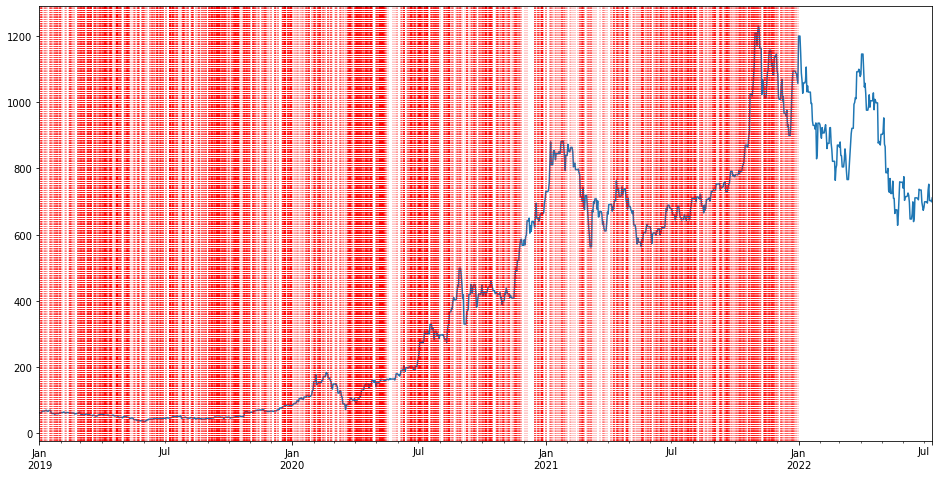

In [36]:
tesla_df.Close.plot(figsize=(16, 8));
for xc in elon_df[elon_df.text.str.lower().str.contains('tesla')].date:
    plt.axvline(x=xc, color='red', dashes=(0.2, 1))